In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [3]:
!ls ../data/images/signatures/

1.jpg  1.png  3.jpg  3.svg


In [36]:
filename = '../data/images/signatures/3.jpg'
# filename = '../data/images/fingerprints/fingerprint43.bmp'
img = np.asarray(Image.open(filename))

In [5]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

In [6]:
def return_uint8(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.uint8)
    return func_wrapper

def return_float32(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.float32)
    return func_wrapper

def get_global_thresholding(img, threshold):
    # http://www.cse.iitd.ernet.in/~pkalra/col783/Thresholding.pdf
    if img.ndim == 2:
        img = np.asarray( Image.fromarray(np.uint8(img * 255) , 'L'))
    else:
        img = to_grayscale(img)
    return np.apply_along_axis(_threshold, -1, img, threshold)
def _threshold(pixel, threshold):
    return [1. if color > threshold else 0. for color in pixel]

In [7]:
def otsu_threshold(im):
    pixel_counts = [np.sum(im == i) for i in range(256)]
    s_max = (0,-10)
    ss = []
    for threshold in range(256):
        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])
        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0
        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)
        if s > s_max[1]:
            s_max = (threshold, s)         
    return s_max[0]

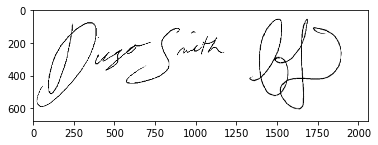

In [24]:
imshow(img, cmap=plt.cm.binary)

Threshold: 134


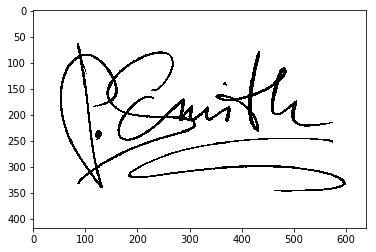

In [37]:
threshold = otsu_threshold(img)
print("Threshold: {}".format(threshold))
binarized = 1-get_global_thresholding(img, threshold)
imshow(binarized, cmap=plt.cm.binary)

In [19]:
def first_marks(img):
    result = np.ndarray(img.shape)
    for (i, j), v in np.ndenumerate(img):
        if img[i, j] == 1:
            result[i,j] = 1
            neighbours = img[i-1:i+2,j-1:j+2]
            try:
                if neighbours[0][1] == 0 or neighbours[1][0] == 0 or neighbours[1][2] == 0 or neighbours[2][1] == 0:
                    result[i, j] = 2
                else:
                    if neighbours[0][0] == 0 or neighbours[0][2] == 0 or neighbours[2][0] == 0 or neighbours[2][2] == 0:
                        result[i, j] = 3
            except IndexError:
                pass
        else:
            result[i, j] = 0
    return result

In [11]:
def get_neighbour_weight(neighbours):
    weight = 0
    if neighbours[0][1] != 0:
        weight += 1
    if neighbours[0][2] != 0:
        weight += 2
    if neighbours[1][2] != 0:
        weight += 4
    if neighbours[2][2] != 0:
        weight += 8
    if neighbours[2][1] != 0:
        weight += 16
    if neighbours[2][0] != 0:
        weight += 32
    if neighbours[1][0] != 0:
        weight += 64
    if neighbours[0][0] != 0:
        weight += 128
    return weight

In [12]:
def check_2_3_4_neighbours(neighbours):
    w = get_neighbour_weight(neighbours)
    return w in [3,6,12,24,48,96,192,129,7,13,28,56,112,224,193,131,15,30,60,120,240,225,195,135]

In [13]:
def delete_4s(img):
    result = np.ndarray(img.shape)
    for (i, j), v in np.ndenumerate(img):
        result[i, j] = img[i, j]
        if img[i, j] == 2 or img[i, j] == 3:
            neighbours = img[i-1:i+2,j-1:j+2]
            try:
                if check_2_3_4_neighbours(neighbours):
                    result[i, j] = 0
            except IndexError:
                pass
    return result

In [14]:
DELETION_ARRAY = [
    3,5,7,12,13,14,15,20,21,22,23,28,29,30,31,48,52,53,54,55,56,60,61,62,63,65,67,69,71,77,79,80,81,83,84,85,86,87,88,89,91,92,93,94,95,97,99,101,103,109,111,112,113,115,116,117,118,119,120,121,123,124,125,126,127,131,133,135,141,143,149,151,157,159,181,183,189,191,192,193,195,197,199,205,207,208,209,211,212,213,214,215,216,217,219,220,221,222,223,224,225,227,229,231,237,239,240,241,243,244,245,246,247,248,249,251,252,253,254,255
]

In [15]:
def delete_ns(img, n):
    result = img
    for (i, j), v in np.ndenumerate(img):
        if result[i, j] == n:
            neighbours = result[i-1:i+2,j-1:j+2]
            try:
                if get_neighbour_weight(neighbours) in DELETION_ARRAY:
                    result[i, j] = 0
                else:
                    result[i, j] = 1
            except IndexError:
                pass
    return result

In [27]:
f = first_marks(binarized)
a = delete_4s(f)
b = delete_ns(a, 3)
b = delete_ns(b, 2)

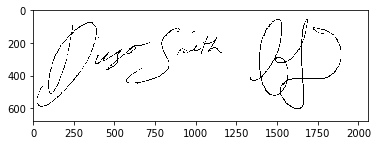

In [28]:
imshow(b, cmap=plt.cm.binary)

# K3M

In [29]:
A0 = [3, 6, 7, 12, 14, 15, 24, 28, 30, 31, 48, 56, 60,
62, 63, 96, 112, 120, 124, 126, 127, 129, 131, 135,
143, 159, 191, 192, 193, 195, 199, 207, 223, 224,
225, 227, 231, 239, 240, 241, 243, 247, 248, 249,
251, 252, 253, 254]
A1 = [7, 14, 28, 56, 112, 131, 193, 224]
A2 = [7, 14, 15, 28, 30, 56, 60, 112, 120, 131, 135,
193, 195, 224, 225, 240]
A3 = [7, 14, 15, 28, 30, 31, 56, 60, 62, 112, 120,
124, 131, 135, 143, 193, 195, 199, 224, 225, 227,
240, 241, 248]
A4 = [7, 14, 15, 28, 30, 31, 56, 60, 62, 63, 112, 120,
124, 126, 131, 135, 143, 159, 193, 195, 199, 207,
224, 225, 227, 231, 240, 241, 243, 248, 249, 252]
A5 = [7, 14, 15, 28, 30, 31, 56, 60, 62, 63, 112, 120,
124, 126, 131, 135, 143, 159, 191, 193, 195, 199,
207, 224, 225, 227, 231, 239, 240, 241, 243, 248,
249, 251, 252, 254]
A1pix = [3, 6, 7, 12, 14, 15, 24, 28, 30, 31, 48, 56,
60, 62, 63, 96, 112, 120, 124, 126, 127, 129, 131,
135, 143, 159, 191, 192, 193, 195, 199, 207, 223,
224, 225, 227, 231, 239, 240, 241, 243, 247, 248,
249, 251, 252, 253, 254]
PHASES = {
    0: A0,
    1: A1,
    2: A2,
    3: A3,
    4: A4,
    5: A5,
}

In [30]:
def iterative_part(result, changed):
    for n in PHASES.keys():
        result, changed = phase_function(result, n, changed)
    for (i, j), v in np.ndenumerate(result):
        if result[i, j] == 2:
            result[i, j] = 1
    return result, changed

In [31]:
def phase_function(img, n, changed):
    result = np.copy(img)
    for (i,j), v in np.ndenumerate(img):
        try:
            if n == 0 and get_neighbour_weight(img[i-1:i+2,j-1:j+2]) in A0:
                result[i, j] = 2
            elif result[i, j] == 2:
                if get_neighbour_weight(result[i-1:i+2,j-1:j+2]) in PHASES[n]:
                    changed = True
                    result[i, j] = 0
        except IndexError:
            pass
    return result, changed

In [41]:
def k3m(img):
    result = np.copy(img)
    result_changed = False
    result, result_changed = iterative_part(result, result_changed)
    i = 0
    while result_changed:
        i += 1
        print(i)
        if i > 250:
            break
        result_changed = False
        result, result_changed = iterative_part(result, result_changed)
    for (i, j), v in np.ndenumerate(result):
        try:
            if result[i, j] != 0 and get_neighbour_weight(result[i-1:i+2,j-1:j+2]) in A1pix:
                result[i, j] = 0
        except IndexError:
            pass
    return result

In [42]:
a = k3m(binarized)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


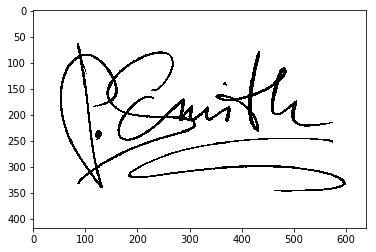

In [43]:
imshow(binarized, cmap=plt.cm.binary)

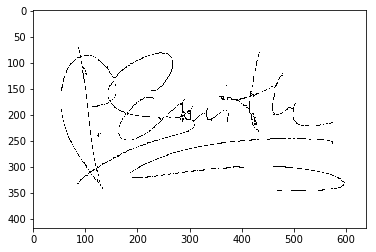

In [44]:
imshow(a, cmap=plt.cm.binary)